In [1]:
import tensorflow as tf
import keras
import numpy as np
from matplotlib import pyplot as plt

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = (X_train[0].astype(np.float32)/255.0).copy()

11493376/11490434 [==============================] - 0s 0us/step


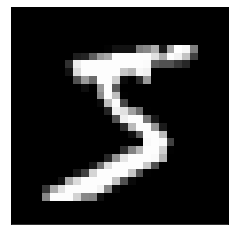

In [3]:
fig, ax = plt.subplots()
ax.imshow(X_train, cmap = plt.cm.gray)
_ = ax.set(xticks = [], yticks = [])

In [4]:
def getBatches(X, batch_size = 10):
    '''
        Generates batches from input, each batch has the same size (mostly)
        Parameters:
            X: tensor of size (n_samples, n_features)
                Input data
            batch_size: int, default: 10
                Size of each batch generated from X (if batch_size divides number of samples evenly)
        Returns: None
    '''
    sample_size = X.shape[0]

    for i in range(0, sample_size, batch_size):
        batch_X = X[i:(i+batch_size), :]
        yield batch_X
class RICA:
    def __init__(self, input_shape, encoder_shape):
        '''
            RICA instances initialization.
            Parameters:
                input_shape: int
                encoder_shape: int
                    Encoder shape, usually encoder shape < input_shape
        '''
        self.input_shape, self.encoder_shape = input_shape, encoder_shape
        self.W = tf.Variable(
            initial_value = tf.random.normal(shape = (self.encoder_shape, self.input_shape), seed = 0),
            trainable = True
        )
    def fit(self, X, epochs, batch_size = 1, learning_rate = 0.01, regularization = 0.1, epsilon = 1e-3, random_state = 0):
        '''
            Update parameter W of RICA.
            Parameters:
                X: tensor-like of shape (n_samples, input_shape)
                    Input data, each row is an observation
                epochs: int
                    Number of epochs
                batch_size: int, default 1
                    If batch_size == 1 -> Perform SGD update on W
                    If 1 < batch_size < n_samples -> Perform Mini Batch SGD on W
                    If batch_size == n_samples -> Perform Batch GD on W
                learning_rate: float, default: 0.01
                    Controls how fast to go down the opposite direction of the gradient
                    The larger/smaller learning_rate the more unstable/slower it is for W to converge
                regularization: float, default: 0.1
                    Regularization on encoder vector in l_1 norm
                    When regularization parameter is large, it means encoder vector will be sparsed
                epsilon: float, default: 1e-3
                    Approximation of l_1 norm: ||x|| = \sqrt{x^2 + epsilon}.
                    The smaller epsilon the more accurate for the approximation
                random_state: int, default 0
                    Random state for reproducibility
            Returns: None
        '''
        tf.random.set_seed(random_state)
        X = tf.constant(X, dtype = tf.dtypes.float32)
        for epoch in range(epochs):
            if batch_size != X.shape[0]:
                X = tf.random.shuffle(X)
            for batch_X in getBatches(X, batch_size = batch_size):
                if batch_size == 1:
                    batch_X = tf.reshape(batch_X, (-1, 1))
                else:
                    batch_X = tf.transpose(batch_X)
                with tf.GradientTape() as tape:
                    # Forward pass
                    encoder = tf.matmul(self.W, batch_X)
                    reconstruct = tf.matmul(tf.transpose(self.W), encoder)
                    reconstruction_loss = tf.reduce_sum(tf.pow(reconstruct - batch_X, 2))
                    regularization_loss = regularization * tf.sqrt(tf.pow(tf.reduce_sum(encoder), 2) + epsilon)
                    loss = reconstruction_loss + 1/2 * regularization_loss
                # Calculate gradient of loss w.r.t W
                gradient = tape.gradient(loss, self.W)
                # Update W
                self.W.assign(self.W - learning_rate * gradient)
        return None
    def reconstruct(self, X):
        '''
            Reconstruct input after encoding.
            Parameters:
                X: tensor-like of shape (n_samples, input_shape)
                    Input data
            Returns: numpy.ndarray of shape (n_samples, input_shape)
        '''
        X = tf.constant(X, dtype = tf.dtypes.float32)
        reconstruct_X = []
        for row in X:
            r = tf.reshape(row, (-1, 1))
            encoder = tf.matmul(self.W, r)
            reconstruct = tf.matmul(tf.transpose(self.W), encoder)
            # reconstruct vector is a column vector -> transform it into row vector
            reconstruct_X.append(tf.reshape(reconstruct, (1, -1)))
        reconstruct_X = tf.concat(reconstruct_X, axis = 0).numpy()
        return reconstruct_X
    def reconstruct_encoder(self, encoder):
        '''
            Reconstruct input from encoder
            Parameters:
                encoder: tensor-like of shape (n_samples, encoder_shape)
                    A set of encoders
            Returns: numpy.ndarray of shape (n_samples, input_shape)
        '''
        X = tf.constant(encoder, dtype = tf.dtypes.float32)
        reconstruct_X = []
        for row in X:
            r = tf.reshape(row, (-1, 1))
            reconstruct = tf.matmul(tf.transpose(self.W), r)
            reconstruct_X.append(tf.reshape(reconstruct, (1, -1)))
        reconstruct_X = tf.concat(reconstruct_X, axis = 0).numpy()
        return reconstruct_X
    def encode(self, X):
        '''
            Encoding input.
            Parameters:
                X: tensor-like of shape (n_samples, input_shape)
                    Input data
            Returns: numpy.ndarray of shape (n_samples, encode_shape)
        '''
        X = tf.constant(X, dtype = tf.dtypes.float32)
        encode_X = []
        for row in X:
            r = tf.reshape(row, (-1, 1))
            encoder = tf.matmul(self.W, r)
            encode_X.append(tf.reshape(encoder, (1, -1)))
        encode_X = tf.concat(encode_X, axis = 0).numpy()
        return encode_X

In [5]:
rica = RICA(input_shape = 28, encoder_shape = 18)
rica.fit(X_train, epochs = 10000, batch_size = 28, learning_rate = 1e-4, regularization = 100, epsilon = 1e-6)

In [6]:
reconstruct_X = rica.reconstruct(X_train)

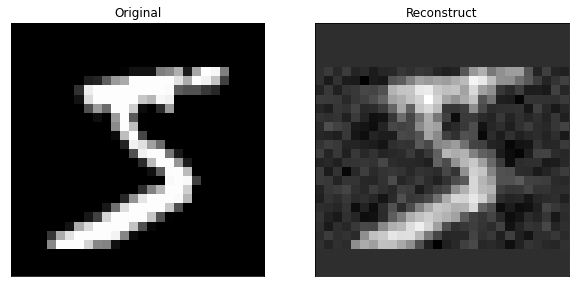

In [7]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 8))
axes[0].imshow(X_train, cmap = plt.cm.gray)
axes[1].imshow(reconstruct_X, cmap = plt.cm.gray)

for i, name in enumerate(('Original', 'Reconstruct')):
    axes[i].set(title = name, xticks = [], yticks = [])

In [8]:
encode = rica.encode(X_train)

In [9]:
encode[0, :]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [10]:
encode[10, :]

array([-0.22836556, -0.1591149 , -0.29303712,  0.14101395,  0.40173262,
        0.4261232 ,  0.07427137, -0.17444286,  0.23605718, -0.40132892,
        0.06379274, -0.10920692, -0.36369395, -0.01880916, -0.11485276,
       -0.43693444, -0.31106305,  0.04926693], dtype=float32)

In [11]:
reconstruct = rica.reconstruct_encoder(encode)

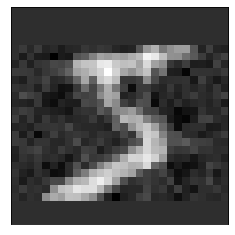

In [12]:
fig, ax = plt.subplots()
ax.imshow(reconstruct, cmap = plt.cm.gray)
_ = ax.set(xticks = [], yticks = [])